In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import sys
sys.path.append('/home/kaigorodov/myprojects/MedConcNorm/')

#from src.features.class_balancing import class_sampler
from src.support_models.triplet_generator import TripletGenerator
from src.support_models.loss_functions import triplet_loss, identity_loss
from src.support_models.base_model import base_model
from src.support_models.siamese_model_architecture import siamese_model

from tqdm import tqdm

In [9]:
from imblearn.over_sampling import RandomOverSampler

In [10]:
from metric_learn import NCA


In [11]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from tensorflow.keras.callbacks import EarlyStopping

In [12]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
# with open('../data/processed/pure_data.pkl', 'rb') as data_file:
#     df = pickle.load(data_file)
    
with open('../data/processed/pure_data_vectorized.pkl', 'rb') as data_file:
    df = pickle.load(data_file)
    
X_train, X_test, y_train, y_test = df

# oversample = RandomOverSampler(sampling_strategy='minority')
# for i in tqdm(range(100)):
#     X_train, y_train = oversample.fit_resample(X_train, y_train)
#X_train, y_train = class_sampler(X_train, y_train)


X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2153, 768), (539, 768), (2153,), (539,))

In [14]:
np.unique(y_train).shape, np.unique(y_test).shape

((432,), (208,))

(<AxesSubplot:ylabel='Count'>, <AxesSubplot:ylabel='Count'>)

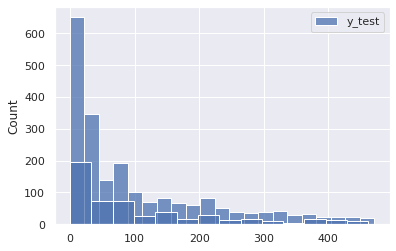

In [15]:
import pandas as pd
import seaborn as sns

sns.histplot(pd.DataFrame({'y_train':y_train})), sns.histplot(pd.DataFrame({'y_test':y_test}))

# Show changes

In [16]:
def scatter(x, labels, subtitle=None):
    palette = np.array(sns.color_palette("hls", 500))
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40, c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

(2153, 2) (2153,)


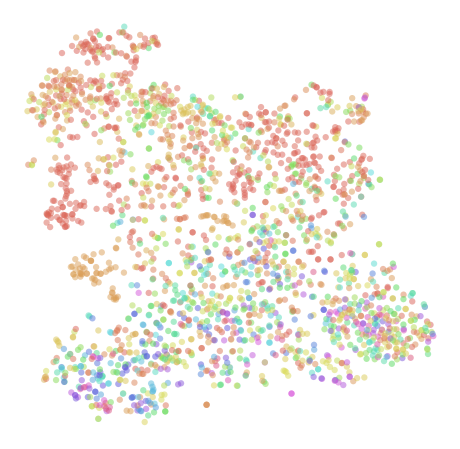

In [17]:
# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
train_tsne = tsne.fit_transform(X_train)
print(train_tsne.shape, y_train.shape)
scatter(train_tsne, y_train)

In [ ]:
model = NCA(max_iter=500)
X_train_nca = model.fit_transform(X_train, y_train)

tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_nca)
print(train_tsne_embeds.shape, y_train.shape)
scatter(train_tsne_embeds, y_train)

In [ ]:
model = NCA(max_iter=3000)
X_train_nca = model.fit_transform(X_train, y_train)

tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_nca)
print(train_tsne_embeds.shape, y_train.shape)
scatter(train_tsne_embeds, y_train)

In [ ]:
tsne = TSNE()
test_tsne = tsne.fit_transform(X_test)
print(test_tsne.shape, y_test.shape)
scatter(test_tsne, y_test)

In [ ]:
tsne = TSNE()
test_tsne_embeds = tsne.fit_transform(X_test_trm)
print(test_tsne_embeds.shape, y_test.shape)
scatter(test_tsne_embeds, y_test)

In [ ]:
tsne = TSNE(n_components=3)
train_to_classify = tsne.fit_transform(X_train_trm)
test_to_classify = tsne.fit_transform(X_test_trm)

train_to_classify.shape, test_to_classify.shape

# Classify

In [ ]:
import pandas as pd
import numpy as np
from copy import copy
import tensorflow as tf
from sklearn.model_selection import train_test_split

import pymedtermino

from metric_learn import NCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

from tpot import TPOTClassifier

generations = 3
population_size = 20
max_eval_time_mins = 1
n_jobs = 10
max_iter = 10

tpot = TPOTClassifier(generations=generations, 
                      population_size=population_size,
                      verbosity=2, 
                      random_state=42, 
                      max_eval_time_mins=max_eval_time_mins, 
                      n_jobs=n_jobs)

tpot.fit(train_tsne_embeds, y_train)

In [ ]:
score = tpot.score(test_tsne_embeds, y_test)
score

score was with low alpha = 0.17439703153988867
score was with 0.2 alpha = 0.11873840445269017